In [67]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

In [68]:
import keras
from keras import layers

IMG_SIZE = 224
BATCH_SIZE = 64

def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')

    model.trainable = False
    outputs = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)

    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [69]:
model = build_model()
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0

In [70]:
def load_and_prep_image(filename, img_shape=224, scale=True):

    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.io.decode_image(img)
    # Resize the image
    img = img[:, :, :3] #remove alpha from a jpg?
    
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img

In [71]:
def load_images_from_file(directory):
    outputs = []
    images = []
    filenames = []
    length_files = []
    
    images_files = os.listdir(directory)
    len_images_files = len(images_files)
    length_files.append(len_images_files)
    
    for i in range(len_images_files):
        filename = images_files[i]
        filepath = directory + filename
    
    
        try:
            # Load the image and make predictions
            img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
    
        except:
            continue;
    
        #print(tf.expand_dims(img, axis=0))
        model_output = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
        outputs.append(model_output.squeeze())
        images.append(img)
        filenames.append(filepath)
    print(f'length of outputs: {len(outputs)} length image files: {len_images_files}')
    return (outputs, images, filenames, length_files)

In [72]:
# Make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt
import numpy as np

def make_preds(folder1, folder2):
    
    outputs, images, filenames, length_files = load_images_from_file(folder1)
    outputs1, images1, filenames1, length_files1 = load_images_from_file(folder2)
    
    outputs.extend(outputs1)
    images.extend(images1)
    filenames.extend(filenames1)
    length_files.extend(length_files1)
    
    print(length_files)
    print(len(outputs))
    print(outputs)
    return (outputs, images, filenames, length_files)

In [73]:
#smaller value defines smaller class therefore use smaller value
def get_eps_value(folder1, folder2):  
    texfile_name = f'{folder1.split("/")[0]}/eps.txt'
    f = open(texfile_name, "r")
    eps = float(f.readline())
    f.close()
    texfile_name = f'{folder2.split("/")[0]}/eps.txt'
    f = open(texfile_name, "r")
    eps1 = float(f.readline())
    f.close()
    return min(eps, eps1)

In [74]:
from PIL import Image

def frame_image(img, frame_width, color=(255, 0, 0)):
    b = frame_width
    ny, nx = img.shape[0], img.shape[1]
    framed_img = Image.new('RGB', (b+ny+b, b+nx+b), color)
    framed_img = np.array(framed_img.getdata()).reshape(framed_img.size[0], framed_img.size[1], 3)
    framed_img[b:-b, b:-b] = img
    return framed_img

In [75]:
def sort_into_classes(classes, y_db, images, length_files):
    clusters = []

    classes_colors = []
    overlaps = []
    for i in range (len(classes)):
        cluster = []
        
        class_colors = []
        overlap = [0, 0]
        for j in range(len(y_db)):
            if y_db[j] == classes[i]:
                cluster.append(images[j])
                
                #colors
                if j >= length_files[0]: #from original picture loader load one set then other
                    class_colors.append((255, 0, 0))
                    overlap[0] += 1
                else:
                    class_colors.append((0, 255, 0))
                    overlap[1] += 1
        print(f"length cluster: {len(cluster)}")
        clusters.append(cluster)
       
        classes_colors.append(class_colors)
        overlaps.append(overlap)

    return (clusters, classes_colors, overlaps)
        

In [76]:
def display_class_overlap(clusters, classes, classes_colors):
    for i in range(len(clusters)):
        print(f"classes: {classes[i]}")
        plt.figure(figsize=(20, 20))
           
        for j in range(len(clusters[i])):
            plt.subplot(len(clusters[i])//10 + 1, 10, j + 1)
            plt.imshow(frame_image(clusters[i][j].numpy(), frame_width = 10, color=classes_colors[i][j]))
            plt.axis(False)
    
        plt.show()

In [79]:
def calculate_similarity(overlaps, length_files, classes):
    sim = 0
    i = 0
    for j in range(len(overlaps)):
        print(f"iteration overlaps: {j}")
        if classes[j] == -1:
            continue
        else:
            sim += (overlaps[j][0] / length_files[0] * overlaps[j][1] / length_files[1])/2
            i+= 1
            print(f"simularity for class {i} is: {sim}")
        sim = sim/i
    print(f"simularity is {sim}")
    return sim

In [80]:
from sklearn.cluster import DBSCAN

black_img = np.zeros(shape=(224, 224, 3))

def compare_the_two_folders(folder1, folder2):
    outputs, images, filenames, length_files = make_preds(folder1, folder2)
    eps = get_eps_value(folder1, folder2)
    print(f"using eps: {eps}")

    db = DBSCAN(eps=eps, min_samples=5, metric='euclidean')
    y_db = db.fit_predict(outputs)
    print(f'length y_db: {len(y_db)}')
    print(y_db)

    classes = np.unique(y_db)
    
    clusters, classes_colors, overlaps = sort_into_classes(classes, y_db, images, length_files)
    display_class_overlap(clusters, classes, classes_colors)

    print(f'overlaps: {overlaps}')
    return calculate_similarity(overlaps, length_files, classes)

In [93]:
folders = ("bears/", "stuffed_toy/", "plushie/")

In [94]:
import os 

folders_list = []

for i in range(len(folders)):
    folder_list = []
    for _, dirs, _ in os.walk(folders[i]):
        for name in dirs:
            folder_list.append(folders[i] + name + "/")
    folders_list.append(folder_list)
folders_list
     

[['bears/class1/', 'bears/class2/', 'bears/class3/'],
 ['stuffed_toy/class1/'],
 ['plushie/class1/']]

In [ ]:
tot_simularities = []
graph_names = []
for i in range(len(folders_list)):
    for j in range(len(folders_list[i])):
        simularities = []
        graph_names.append(folders_list[i][j])

        
        for m in range(len(folders_list)):
            for n in range(len(folders_list[m])):
                print(f"{i} + {j}: {m} + {n}")
                if m > i:
                    simularities.append(compare_the_two_folders(folders_list[i][j], folders_list[m][n]))
                else:
                    simularities.append(-1)

        tot_simularities.append(simularities)

print(tot_simularities)
print(graph_names)

In [96]:
import pandas as pd
df = pd.DataFrame(tot_simularities, columns=graph_names, index=graph_names)
df

,bears/class1/,bears/class2/,bears/class3/,stuffed_toy/class1/,plushie/class1/
bears/class1/,-1,-1,-1,0.000000,0.000000
bears/class2/,-1,-1,-1,0.000000,0.000000
bears/class3/,-1,-1,-1,0.124242,0.024336
stuffed_toy/class1/,-1,-1,-1,-1.000000,0.500000
plushie/class1/,-1,-1,-1,-1.000000,-1.000000


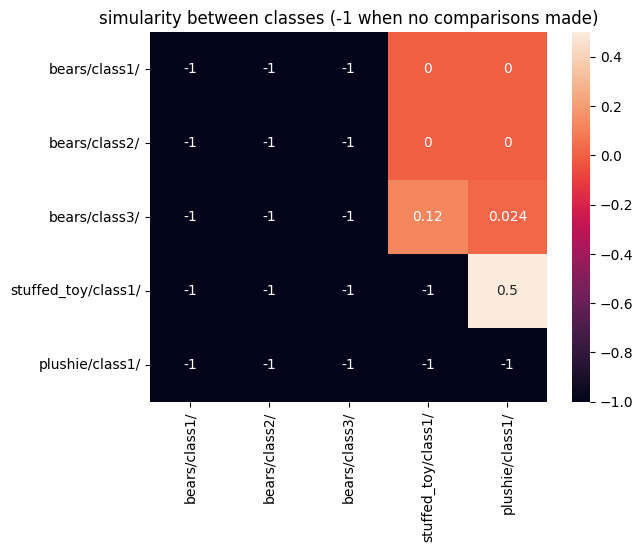

In [98]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(df, annot=True)
ax.set_title("simularity between classes (-1 when no comparisons made)")
plt.show()

In [ ]:
from mlxtend.plotting import heatmap ###
import numpy as np
cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=val_y,
                 y_pred= tf.squeeze(tf.cast(tf.round(y_probs), dtype='int64')))

In [ ]:
make_confusion_matrix(y_true=val_y,
                      y_pred=y_probs,
                      classes=class_names,
                      figsize=(5, 5))